An overview of the application of mathematics in technical indicators. 

Import packages: 
* numpy to mathematical 
* pandas to general Python 
* matplotlib.pyplot to generate visualizations
* matplotlib.dates to update data type for visualization
* datetime to work with date type data
* yfinance to import stock data from Yahoo Finance
* candlestick_ohlc to generate the candlestick chart

In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import yfinance as yf
from mplfinance.original_flavor import candlestick_ohlc

Define the date range.

In [226]:
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=365)

Select a security ticker to retrieve its stock data.

In [227]:
stock = 'XIC.TO'
df = yf.download(stock, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


Develop Open-High-Low-Close data for the candlestick chart.

In [228]:
copied_df = df.copy()
copied_df = copied_df.reset_index() 
copied_df['Date'] = pd.to_datetime(copied_df['Date'])
copied_df['Date'] = copied_df['Date'].apply(mdates.date2num)
ohlc_data = copied_df[['Date', 'Open', 'High', 'Low', 'Close']].values


Calculate the 20-day and 50-day Exponential Moving Averages (EMA).

In [229]:
df['20-day SMA'] = df['Close'].rolling(window=20).mean()
df['50-day SMA'] = df['Close'].rolling(window=50).mean()
df['20-day EMA'] = df['Close'].ewm(span=20, adjust=False).mean()
df['50-day EMA'] = df['Close'].ewm(span=50, adjust=False).mean()

Calculate Moving Average Convergence/Divergence (MACD) and Signal Line (SL).

In [230]:
short_ema = df['Close'].ewm(span=12, adjust=False).mean()  
long_ema = df['Close'].ewm(span=26, adjust=False).mean()  
df['MACD'] = short_ema - long_ema 
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()  
df['Histogram'] = df['MACD'] - df['Signal_Line']  

Calculate the Relative Strength Index (RSI).

In [231]:
delta = df['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
RS = gain / loss
df['RSI'] = 100 - (100 / (1 + RS))

Calculate the Stochastic Oscillator.

In [232]:
df['Lowest_Low'] = df['Low'].rolling(window=14).min()
df['Highest_High'] = df['High'].rolling(window=14).max()
df['%K'] = (df['Close'] - df['Lowest_Low']) / (df['Highest_High'] - df['Lowest_Low']) * 100
df['%D'] = df['%K'].rolling(window=3).mean()
df.drop(['Lowest_Low', 'Highest_High'], axis=1, inplace=True)


Plot visualizations.

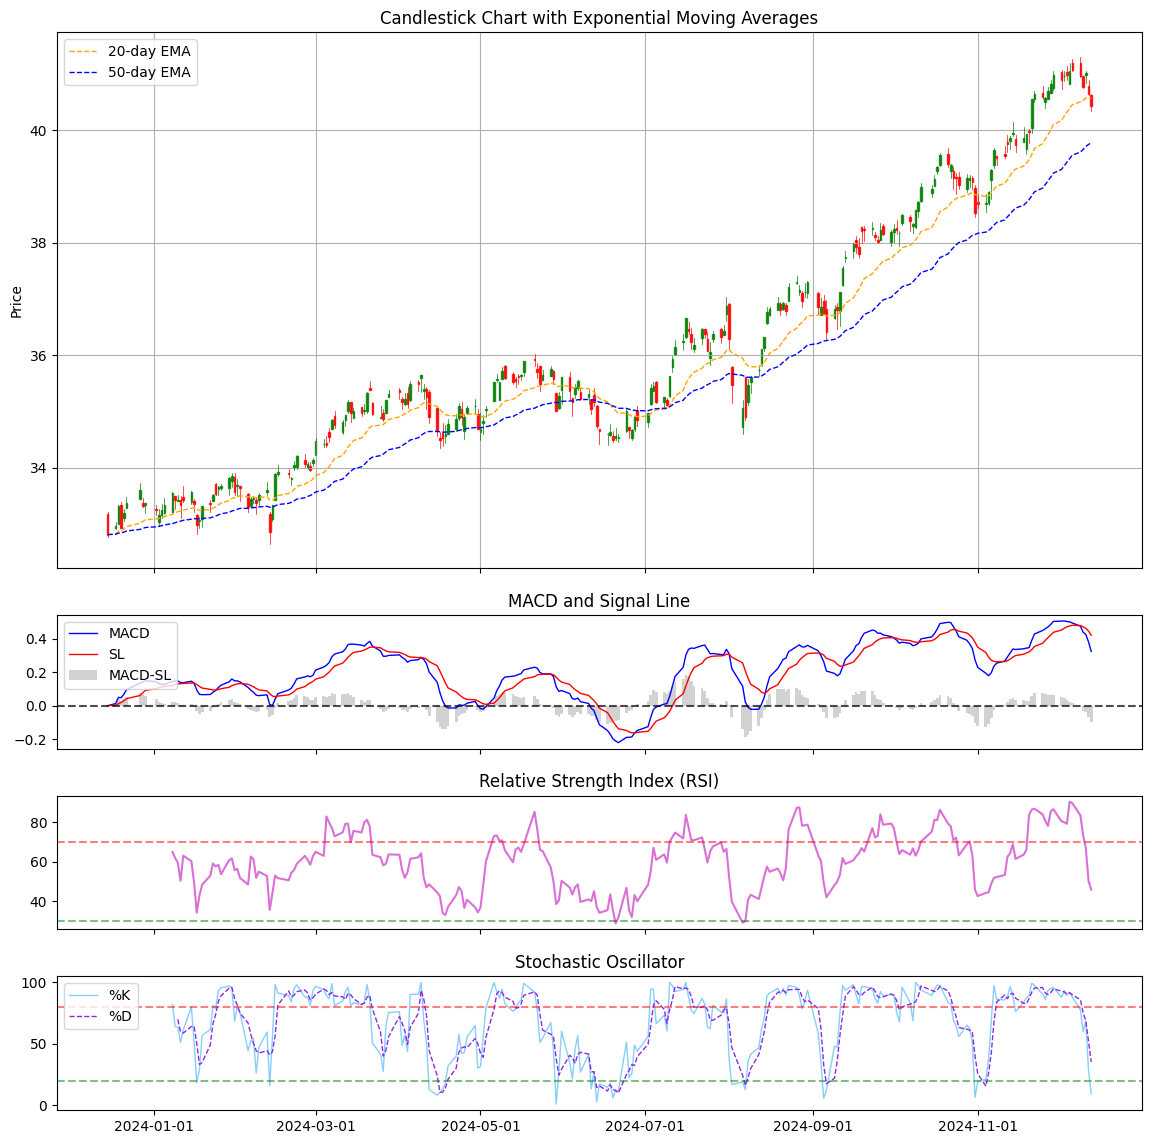

In [233]:
# Visualization layout
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 14), sharex=True, gridspec_kw={'height_ratios': [4, 1, 1, 1]})
# Candlesticks Chart with EMAs
candlestick_ohlc(ax1, ohlc_data, width=0.6, colorup='green', colordown='red', alpha=0.8)
ax1.plot(df.index, df['20-day EMA'], label='20-day EMA', color='orange', linewidth=1, linestyle='--')
ax1.plot(df.index, df['50-day EMA'], label='50-day EMA', color='blue', linewidth=1, linestyle='--')
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.set_title('Candlestick Chart with Moving Averages')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True)
ax1.legend()
ax1.tick_params(axis='x', rotation=0)
ax1.set_title('Candlestick Chart with Exponential Moving Averages')
# MACD
ax2.plot(df.index, df['MACD'], label='MACD', color='blue', linewidth=1)
ax2.plot(df.index, df['Signal_Line'], label='SL', color='red', linewidth=1)
ax2.bar(df.index, df['Histogram'], label='MACD-SL', color='silver', alpha=0.7, width=1.0)
ax2.set_title('MACD and Signal Line')
ax2.axhline(0, linestyle='--', color='black', alpha=0.7)
ax2.legend(loc='upper left')
# RSI
ax3.plot(df.index, df['RSI'], label='RSI', color='orchid')
ax3.axhline(70, linestyle='--', alpha=0.5, color='red')
ax3.axhline(30, linestyle='--', alpha=0.5, color='green')
ax3.set_title('Relative Strength Index (RSI)')
# Stochastic Oscillator
ax4.plot(df.index, df['%K'], label='%K', color='lightskyblue', linewidth=1)
ax4.plot(df.index, df['%D'], label='%D', color='blueviolet', linewidth=1, linestyle='--')
ax4.axhline(80, linestyle='--', color='red', alpha=0.5)
ax4.axhline(20, linestyle='--', color='green', alpha=0.5)
ax4.set_title('Stochastic Oscillator')
ax4.legend(loc='upper left')

Now we are shifting to leveraging these indicators together in a machine learning model to predict stock prices.

[*********************100%%**********************]  1 of 1 completed


Mean Squared Error: 13.470201697371357


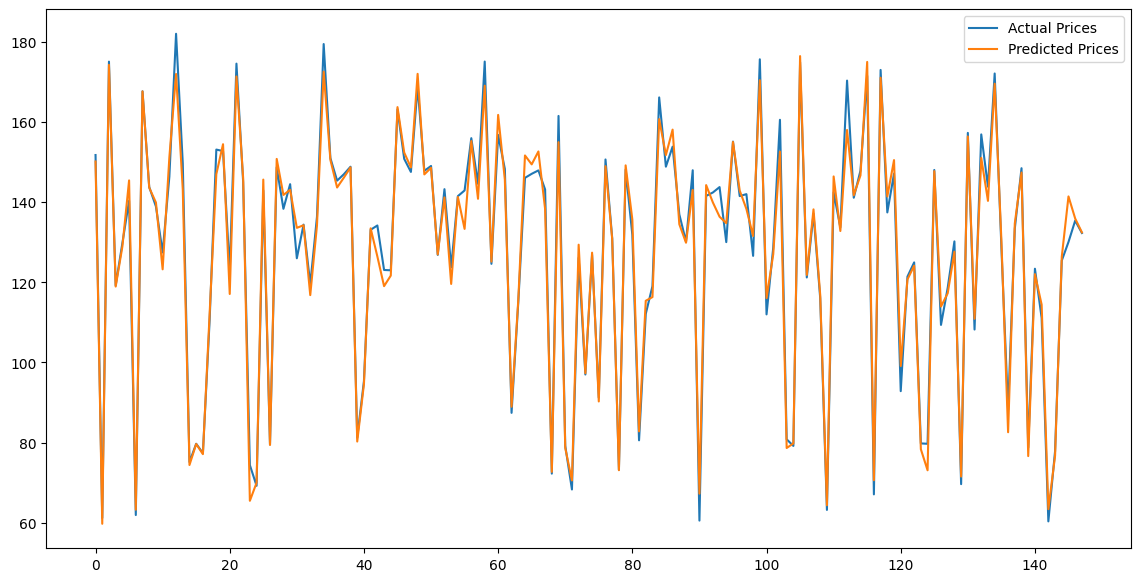

In [13]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Fetch stock data
def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Calculate technical indicators
def calculate_technical_indicators(data):
    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))
    return data

# Prepare data for machine learning
def prepare_data(data):
    data = data.dropna()
    X = data[['SMA_20', 'EMA_20', 'RSI']]
    y = data['Close'].shift(-1).dropna()
    X = X[:-1]
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Train and predict using RandomForestRegressor
def predict_stock_prices(X_train, X_test, y_train, y_test):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    return predictions, mse

# Plot results
def plot_results(y_test, predictions):
    plt.figure(figsize=(14, 7))
    plt.plot(y_test.values, label='Actual Prices')
    plt.plot(predictions, label='Predicted Prices')
    plt.legend()
    plt.show()

# Main function
def main():
    ticker = 'AAPL'
    start_date = '2020-01-01'
    end_date = '2023-01-01'
    
    stock_data = fetch_stock_data(ticker, start_date, end_date)
    stock_data = calculate_technical_indicators(stock_data)
    X_train, X_test, y_train, y_test = prepare_data(stock_data)
    
    predictions, mse = predict_stock_prices(X_train, X_test, y_train, y_test)
    
    print(f'Mean Squared Error: {mse}')
    plot_results(y_test, predictions)

if __name__ == "__main__":
    main()
